In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import keras

In [2]:
train_df = pd.read_csv('../CheXpert-v1.0-small/train.csv')

In [3]:
train_df = train_df[train_df['Frontal/Lateral']=='Frontal']

In [4]:
train_df.shape[0]

191027

In [21]:
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [26]:
classes = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity' ,
                   'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
                   'Pleural Effusion', 'Pleural Other', 'Fracture','Support Devices']

In [28]:
train_dfc = train_df[classes]

In [30]:
train_dfc.columns

Index(['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
       'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
       'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
       'Fracture', 'Support Devices'],
      dtype='object')

In [37]:
class DataGenerator(keras.utils.Sequence):
    'Data Generetor for CheXpert'
    def __init__(self, train_file,classes, data_dir, batch_size=32, dim=(390*320), n_channels=1,
                  shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.classes = classes
        self.n_classes = len(self.classes)
        self.dim = dim
        self.data_dir = data_dir
        self.shuffle = shuffle
        self.policy = 'ones'
        
        self.train_df = pd.read_csv(train_file)
        self.train_df = self.train_df[self.train_df['Frontal/Lateral']=='Frontal']
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.train_df.shape[0]) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        curr_batch = self.train_df.iloc[indexes]
        # Generate data
        X, y = self.__data_generation(curr_batch)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.train_df.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, curr_batch):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)

        # Generate data
        for index, row in curr_batch.iterrows():
            # Image
            img = Image.open(os.path.join(self.data_dir,row['Path']))
            img = img.resize(self.dim, Image.ANTIALIAS)
            X[i,] = np.array(img)

            # Label
            labels=[]
            for cls in self.classes:
                curr_val = row[cls]
                feat_val = 0
                if curr_val:
                        curr_val = float(curr_val)
                        if curr_val == 1:
                            feat_val = 1
                        elif curr_val == -1:
                            if self.policy == "ones":
                                feat_val = 1
                            elif self.policy == "zeroes":
                                feat_val = 0
                            else:
                                feat_val = 0
                        else:
                            feat_val = 0
                else:
                        feat_val = 0
                labels.append(feat_val)
                    
            y[i,] = labels

        return X, y

In [5]:
import cv2

In [17]:
img = Image.open('../CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg')   

In [19]:
img = img.resize((390,320), Image.ANTIALIAS)

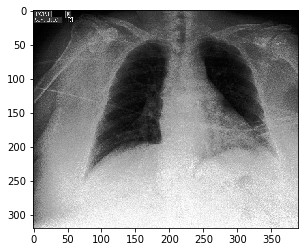

In [20]:
plt.imshow(img)

In [38]:
train_file = '../CheXpert-v1.0-small/train.csv'
data_dir = '../'
dg = DataGenerator(train_file, classes, data_dir)